In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
import pickle
from tqdm import tqdm

import torch

from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image

from torch.utils.data import DataLoader

import pytorch_lightning as pl
from torchmetrics import Accuracy
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
images, labels = pickle.load(open('images_10_3_normal.p', 'rb'))

In [3]:
images.shape

(11177, 100, 100, 3)

In [4]:
# Split the classes in a balanced way
def train_test_split(labels, split_ratio=0.8):
    # Calculate the class frequencies
    class_counts = Counter(labels)

    # Calculate the number of samples in the train and test sets
    num_samples = len(labels)
    split_ratio = split_ratio 
    num_train_samples = int(num_samples * split_ratio)
    num_test_samples = num_samples - num_train_samples

    # Create a list of tuples, where each tuple contains the class label and the corresponding indices of the samples
    label_indices = [(label, np.where(labels == label)[0]) for label in class_counts.keys()]

    # Initialize the train and test sets
    train_indices = []
    test_indices = []

    # Loop over the list of tuples
    for label, indices in label_indices:
        # Calculate the number of samples for this class
        num_samples = len(indices)

        # Calculate the number of samples in the train and test sets for this class
        num_train_samples = int(num_samples * split_ratio)
        num_test_samples = num_samples - num_train_samples

        # Select the train and test indices for this class
        train_indices += random.sample(list(indices), num_train_samples)
        test_indices += [i for i in indices if i not in train_indices]
    return train_indices, test_indices

In [5]:
# check if they are balanced?

train_indices, test_indices = train_test_split(labels, split_ratio=0.4)

np.unique(labels[train_indices], return_counts=True), np.unique(labels[test_indices], return_counts=True)

((array([0, 1]), array([3866,  604])), (array([0, 1]), array([5800,  907])))

In [6]:
num_classes = len(np.unique(labels, return_counts=False))
num_classes

2

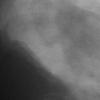

In [7]:
Image.fromarray(images[1])

In [8]:
model_name_or_path = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [9]:
label2id = {}
id2label = {}

for i, class_name in enumerate(range(num_classes)):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name
    
id2label, label2id

({'0': 0, '1': 1}, {0: '0', 1: '1'})

In [10]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

In [11]:
class DDSM(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, label = Image.fromarray(self.images[idx]), self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [12]:
# create data loaders

train_ds = DDSM(images[train_indices], labels[train_indices])
val_ds = DDSM(images[test_indices], labels[test_indices])

In [13]:
collator = ImageClassificationCollator(feature_extractor)

train_loader = DataLoader(train_ds, batch_size=32, collate_fn=collator, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=32, collate_fn=collator, num_workers=4)

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
d = next(iter(train_loader))
model(**d)

SequenceClassifierOutput(loss=tensor(1.0349, grad_fn=<NllLossBackward>), logits=tensor([[ 3.3966e-01, -1.1650e-01],
        [-7.0921e-01,  6.9799e-01],
        [-1.2424e+00,  2.1976e-01],
        [-1.3336e+00, -4.0834e-01],
        [-6.2300e-01,  6.8276e-01],
        [-1.0801e+00,  9.5598e-03],
        [-9.9653e-01,  3.8181e-01],
        [ 8.8048e-03, -2.3753e-01],
        [-6.7323e-01,  4.2761e-01],
        [ 1.9702e-01,  2.3617e-01],
        [-9.3411e-01, -1.4830e-01],
        [-2.2634e-02,  1.7184e-01],
        [-9.5800e-01,  4.5360e-02],
        [ 4.9833e-04,  6.0596e-02],
        [-3.4425e-01,  2.2308e-01],
        [ 1.8969e-01, -3.2284e-01],
        [-1.0956e+00, -1.5307e-01],
        [-7.9946e-01, -5.4977e-01],
        [ 3.5403e-01,  8.2225e-01],
        [-4.9804e-01,  3.3678e-01],
        [-1.0759e+00, -1.8202e-01],
        [-2.9130e-01, -6.5631e-01],
        [-9.6730e-02,  2.5789e-01],
        [-6.4743e-01,  1.9111e-01],
        [-1.1755e+00, -7.3562e-02],
        [-1.0249e+00

In [15]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(task='binary' if num_classes==2 else 'multiclass')
        self.train_acc= Accuracy(task='binary' if num_classes==2 else 'multiclass')

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        acc1 = self.train_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"train_acc", acc1, prog_bar=True)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr,weight_decay=0.0025)

In [17]:
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./vit_content/trainmebby',
    filename='ViT-{epoch:02d}-{val_loss:.2f}',
)
trainer = pl.Trainer(callbacks=[checkpoint_callback], max_epochs=20, gpus=1)
trainer.fit(classifier, train_loader, val_loader)
trainer.save_checkpoint("vit_final_Trained.ckpt")


Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | ViTForImageClassification | 85.8 M
1 | val_acc   | BinaryAccuracy            | 0     
2 | train_acc | BinaryAccuracy            | 0     
--------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.201   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [25]:
def prediction(image):
  im=Image.fromarray(image)
  encoding = feature_extractor(images=[im], return_tensors="pt")

  pixel_values = encoding['pixel_values']

  outputs = model(pixel_values)
  result = outputs.logits.softmax(1).argmax(1)
  new_result = result.tolist()
  return([id2label[str(i)] for i in new_result])

In [29]:
preds = []
for im, lb in tqdm(zip(images[test_indices], labels[test_indices])):
    preds.append(prediction(im)[0])

6707it [15:38,  7.14it/s]


In [30]:
(np.asarray(preds) == labels[test_indices]).mean()

0.9458774414790517

In [ ]:
# predictions = []
# true_labels = []
# for d in tqdm(val_loader):
#     true_labels.append(d["labels"])
#     outputs = model(d["pixel_values"])
#     predictions.append(outputs.logits.softmax(1))

# predictions = torch.cat(predictions)
# true_labels = torch.cat(true_labels)